# Assignment-2 | Part-1 | Question-2

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Gridworld dimensions
grid_size = 5

# Discount factor
gamma = 0.95

# Initialize the value function
V = np.zeros((grid_size, grid_size))

# Define the actions
actions = ['up', 'down', 'left', 'right']
action_probs = [0.25, 0.25, 0.25, 0.25]

# Define the special states and their effects
special_states = {
    (0, 1): (3, 2, 5),
    (0, 4): [(4, 4, 2.5, 0.5), (3, 2, 2.5, 0.5)]
}

# Returen next S' and R(t+1) once St and At is given
def get_next_state_and_reward(state, action):
    if state in special_states:
        if state == (0, 4):
            next_state = special_states[state][np.random.choice([0, 1], p=[0.5, 0.5])]
            return (next_state[0], next_state[1]), next_state[2]
        return special_states[state][:2], special_states[state][2]

    x, y = state
    if action == 'up':
        x = max(x - 1, 0)
    elif action == 'down':
        x = min(x + 1, grid_size - 1)
    elif action == 'left':
        y = max(y - 1, 0)
    elif action == 'right':
        y = min(y + 1, grid_size - 1)

    # reward is 0 for normal states, -0.5 for attempts to step off the grid
    reward = 0
    if (x, y) == state:  # Attempt to step off the grid
        reward = -0.5

    return (x, y), reward


# Initialize the policy
policy = {}
for i in range(grid_size):
    for j in range(grid_size):
        policy[(i, j)] = np.random.choice(actions, p=action_probs)


In [22]:
# Function to plot the gridworld
def plot_gridworld(policy,Title):
    grid_size = 5
    fig, ax = plt.subplots(figsize=(8, 8))

    rect1 = plt.Rectangle((0.5,-0.5), 1, 1, facecolor='blue', edgecolor='black')
    ax.add_patch(rect1)
    rect2 = plt.Rectangle((3.5,-0.5), 1, 1, facecolor='green', edgecolor='black')
    ax.add_patch(rect2)
    rect3 = plt.Rectangle((1.5,2.5), 1, 1, facecolor='red', edgecolor='black')
    ax.add_patch(rect3)
    rect4 = plt.Rectangle((3.5,3.5), 1, 1, facecolor='yellow', edgecolor='black')
    ax.add_patch(rect4)

    for i in range(grid_size):
        for j in range(grid_size):
            # ax.text(j, i, round(policy[i,j],2), ha='center', va='center', fontsize=8)
            ax.text(j, i, policy[i,j], ha='center', va='center', fontsize=8)

    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both')
    ax.set_xticks(np.arange(-0.5, grid_size, 1), minor=False)
    ax.set_yticks(np.arange(-0.5, grid_size, 1), minor=False)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    plt.title(Title)
    plt.gca().invert_yaxis()
    plt.show()

In [23]:
# Function to return more than one optimal action if you have same value for two actions
def action_search(sv):
    max_value=max(sv)
    max_indices = [i for i, x in enumerate(sv) if x == max_value]
    d1=d2=d3=d4=''
    for k in max_indices:
        if k==0:
            d1="up "
        elif k==1:
            d2="Down "
        elif k==2:
            d3="Left "
        elif k==3:
            d4="Right "
    return(d1+d2+d3+d4)    

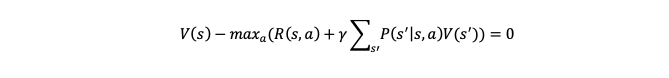

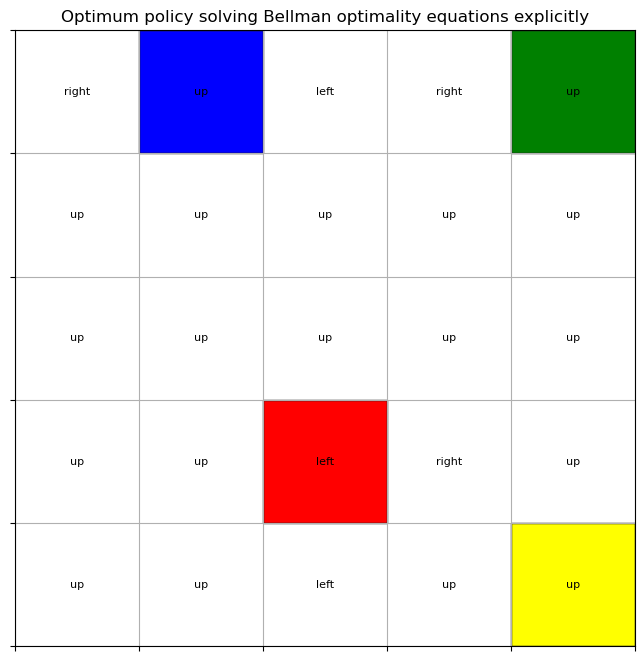

In [24]:
# Solving set of Bellman equation by FSOLVE function
np.random.seed(100)

# Generate set of equations Vx-(max_a(R+gamma*Vs')) for all the states
def bellman_equations(X):
    equations = np.zeros(grid_size*grid_size)
    for x in range(grid_size):
        for y in range(grid_size):
            state_index = x * grid_size + y
            max_value = float('-inf')  
            for action in actions:
                (new_x, new_y), reward = get_next_state_and_reward((x, y), action)
                s_prime = new_x * grid_size + new_y
                max_value = max(max_value, reward + gamma * X[s_prime]) #Find optimum action
            equations[state_index] = X[state_index] - max_value
    return equations

# Initial guess for the value function
initial_guess = np.zeros(grid_size*grid_size)

# Solve the system of equations
solution = fsolve(bellman_equations, initial_guess)

# Reshape value function for grid visualization
V_grid = solution.reshape((grid_size, grid_size))
# print(V_grid)

# One step look ahead to find optimal policy
for x in range(grid_size):
    for y in range(grid_size):
        action_values = []
        for action in actions:
            (new_x, new_y), reward = get_next_state_and_reward((x, y), action)
            action_values.append(reward + gamma * V_grid[new_x, new_y])
        best_action = actions[np.argmax(action_values)]
        # best_action=action_search(np.ceil(action_values * 100) / 100)
        policy[(x, y)] = best_action

OA=np.full((grid_size, grid_size), "", dtype=object)
for x in range(grid_size):
    for y in range(grid_size):
        OA[x, y] = policy[x, y]
plot_gridworld(OA,"Optimum policy solving Bellman optimality equations explicitly")

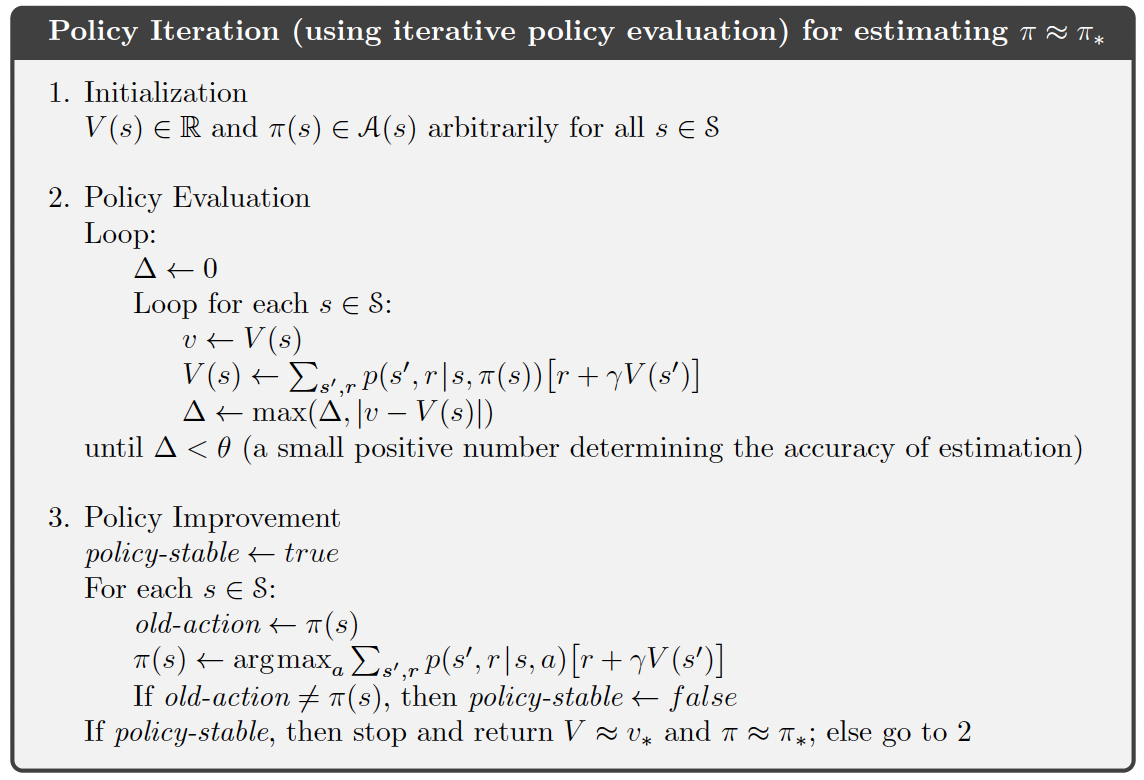

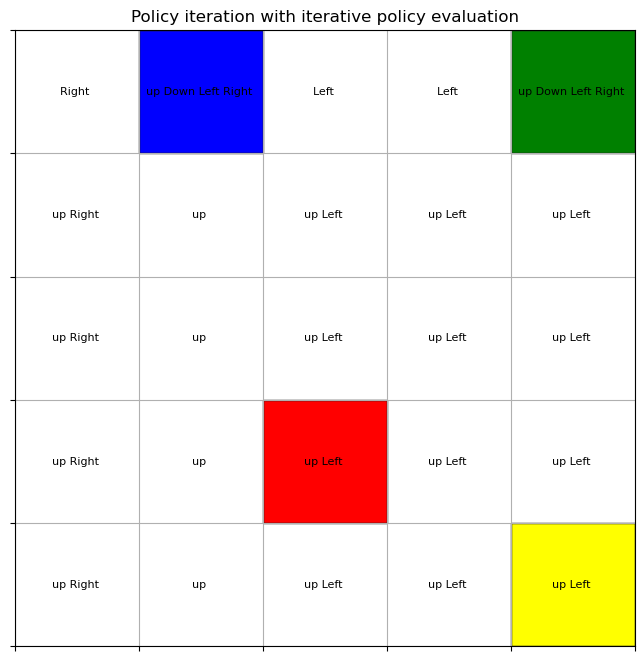

In [59]:
# Policy evaluation
def policy_evaluation(policy, V, threshold=1e-4):
    while True:
        delta = 0
        for x in range(grid_size):
            for y in range(grid_size):
                v = V[x, y]
                new_v = 0
                action = policy[(x, y)]
                (new_x, new_y), reward = get_next_state_and_reward((x, y), action)
                new_v = reward + gamma * V[new_x, new_y]
                V[x, y] = new_v
                delta = max(delta, abs(v - new_v))
        if delta < threshold:
            break
    return V

# Policy improvement
def policy_improvement(policy, V):
    while True:
        V = policy_evaluation(policy, V)
        policy_stable = True
        for x in range(grid_size):
            for y in range(grid_size):
                old_action = policy[(x, y)]
                action_values = []
                for action in actions:
                    (new_x, new_y), reward = get_next_state_and_reward((x, y), action)
                    action_values.append(reward + gamma * V[new_x, new_y])
                best_action = actions[np.argmax(action_values)]
                policy[(x, y)] = best_action
                if old_action != best_action:
                    policy_stable = False
        if policy_stable:
            break
    return policy, V

# Initialization
V_policy_iter = np.zeros((grid_size, grid_size))
policy_iter = {state: np.random.choice(actions) for state in policy} #generate random policy for all states
policy_iter, V_policy_iter = policy_improvement(policy_iter, V_policy_iter)

# Find multiple optimal actions
for x in range(grid_size):
        for y in range(grid_size):
            action_values = []
            for action in actions:
                (new_x, new_y), reward = get_next_state_and_reward((x, y), action)
                action_values.append(reward + gamma * V_policy_iter[new_x, new_y])
            best_action=action_search(np.ceil(action_values * 100) / 100)
            policy[(x, y)] = best_action

# plot in gridworl
OA=np.full((grid_size, grid_size), "", dtype=object)
for x in range(grid_size):
    for y in range(grid_size):
        OA[x, y] = policy[x, y]
plot_gridworld(OA,"Policy iteration with iterative policy evaluation")

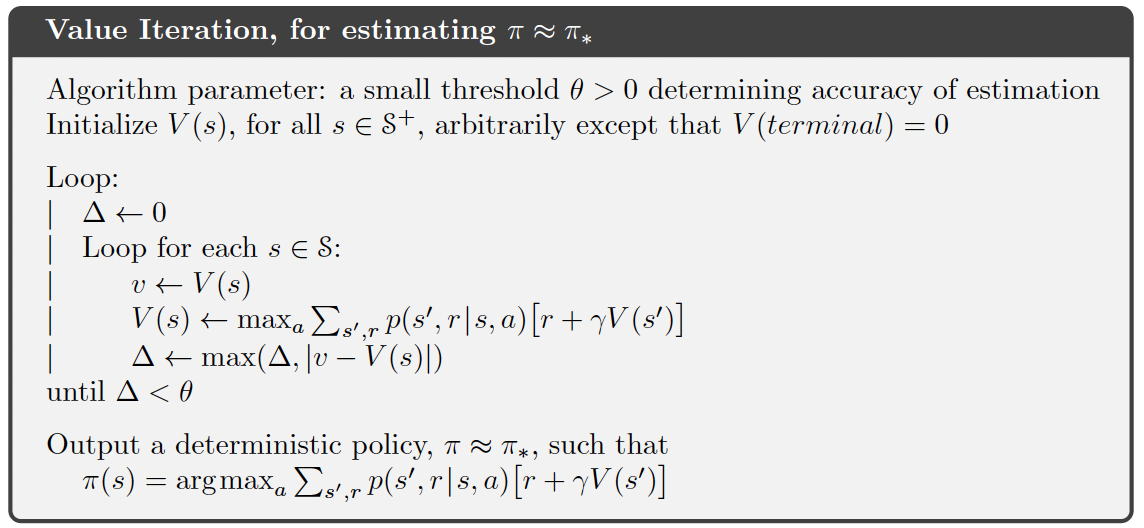

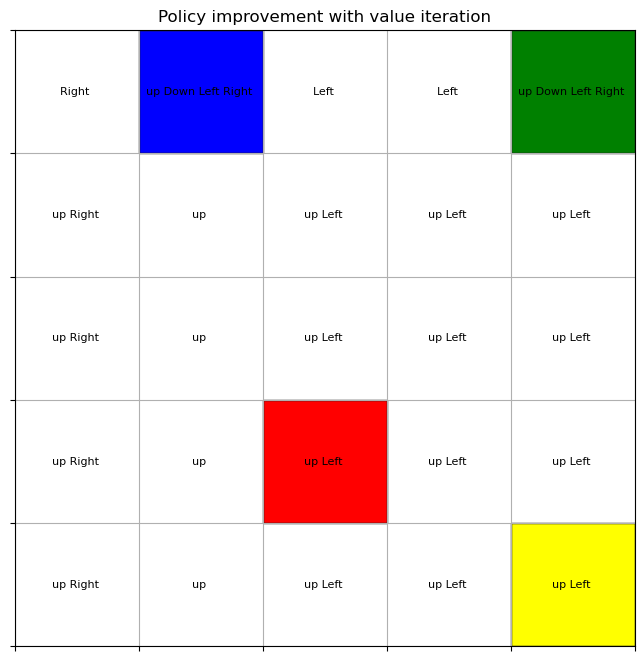

In [50]:
# Loop for value iteration
def value_iteration(V, threshold=1e-4):
    policy = {}
    while True:
        delta = 0
        for x in range(grid_size):
            for y in range(grid_size):
                v = V[x, y]
                action_values = []
                for action in actions:
                    (new_x, new_y), reward = get_next_state_and_reward((x, y), action)
                    action_values.append(reward + gamma * V[new_x, new_y])
                new_v = max(action_values)
                V[x, y] = new_v
                delta = max(delta, abs(v - new_v))
        if delta < threshold:
            break
    return V
# Initialize
V_value_iter = np.zeros((grid_size, grid_size))
V_value_iter = value_iteration(V_value_iter)

# Find multiple optimal actions
for x in range(grid_size):
    for y in range(grid_size):
        action_values = []
        for action in actions:
            (new_x, new_y), reward = get_next_state_and_reward((x, y), action)
            action_values.append(reward + gamma * V_value_iter[new_x, new_y])
        # best_action = actions[np.argmax(action_values)]
        best_action=action_search(np.ceil(action_values * 100) / 100)
        policy[(x, y)] = best_action

# Plot in gridworl
OA=np.full((grid_size, grid_size), "", dtype=object)
for x in range(grid_size):
    for y in range(grid_size):
        OA[x, y] = policy[x, y]
plot_gridworld(OA,"Policy improvement with value iteration")